In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [3]:
df = pd.read_excel('C:\\Users\\PMLS\\1.python\\Online Retail.xlsx')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


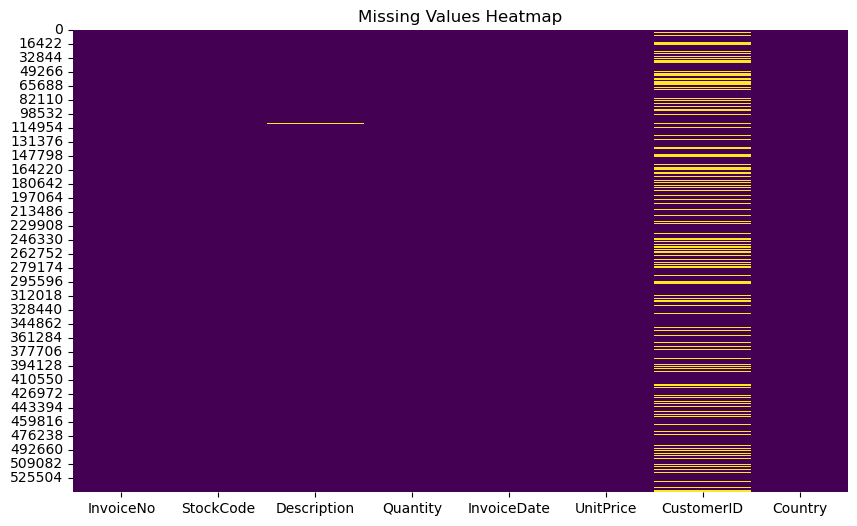

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

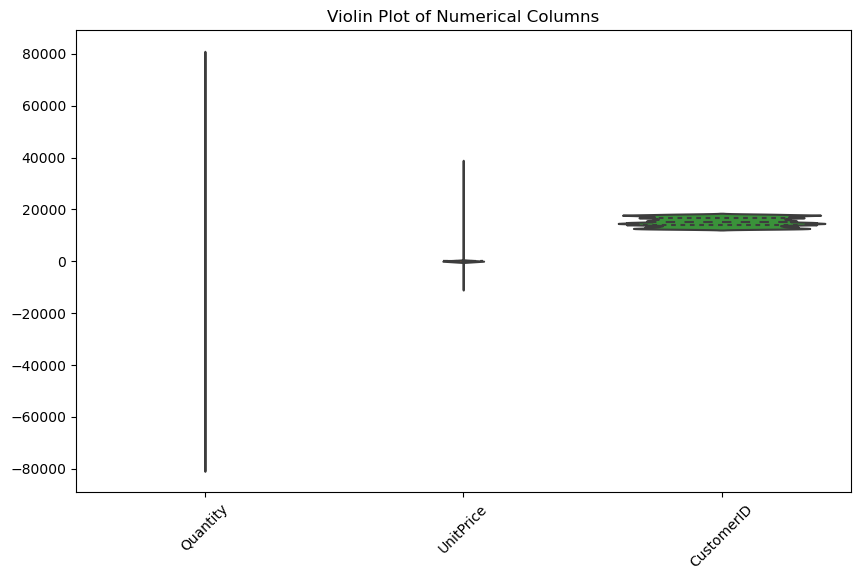

In [11]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[num_cols], inner="quartile")
plt.xticks(rotation=45)
plt.title("Violin Plot of Numerical Columns")
plt.show()

In [12]:
df = df.dropna(subset=['CustomerID'])  
df = df.drop(columns=['Description'])

In [13]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [14]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [15]:
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',     
    'Quantity': 'sum',        
    'InvoiceNo': 'nunique'   
}).rename(columns={'InvoiceNo': 'NumTransactions'})

In [16]:
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

In [18]:
print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4338, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


         TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.184541   4.411906         1.284167
1          7.797363   7.275963         6.318374
2         10.774052  10.306704       121.750000
3          6.442695   5.888930         2.410431
4          9.307641   8.705375        23.259459


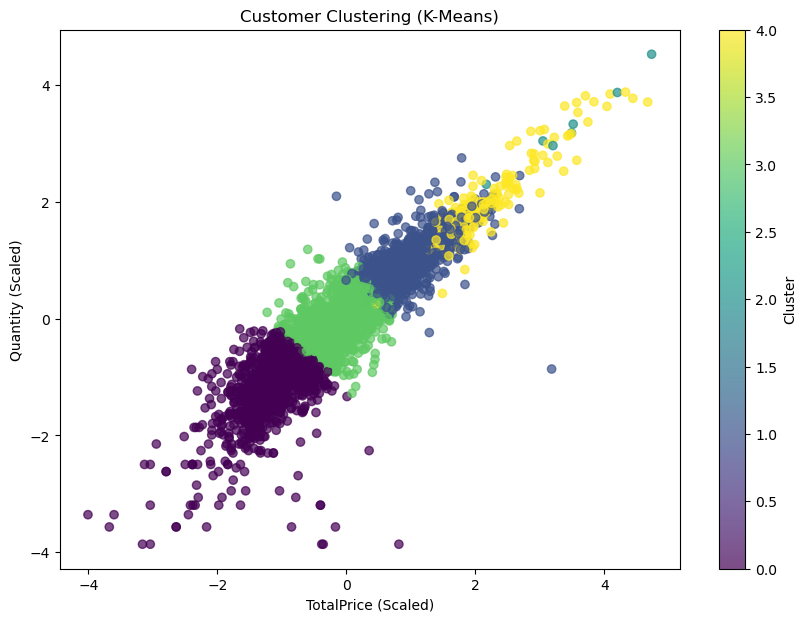

In [19]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

print(customer_data.groupby('Cluster').mean())

plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.title("Customer Clustering (K-Means)")
plt.colorbar(label="Cluster")
plt.show()

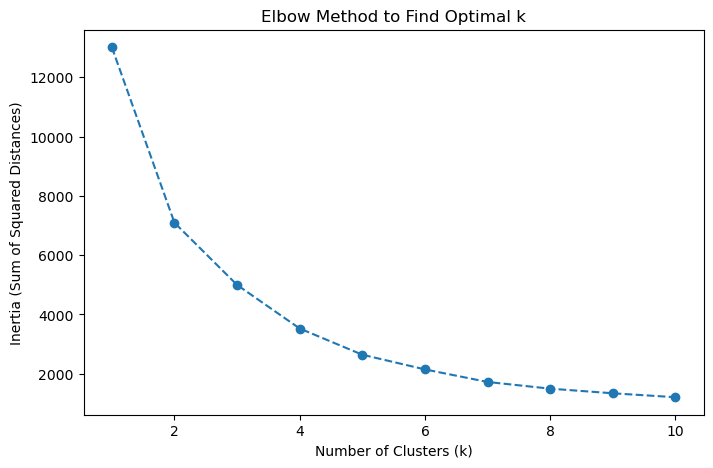

In [20]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method to Find Optimal k")
plt.show()

         TotalPrice  Quantity  NumTransactions
Cluster                                       
0          5.809018  5.153703         1.774096
1          7.832582  7.300823         8.216409


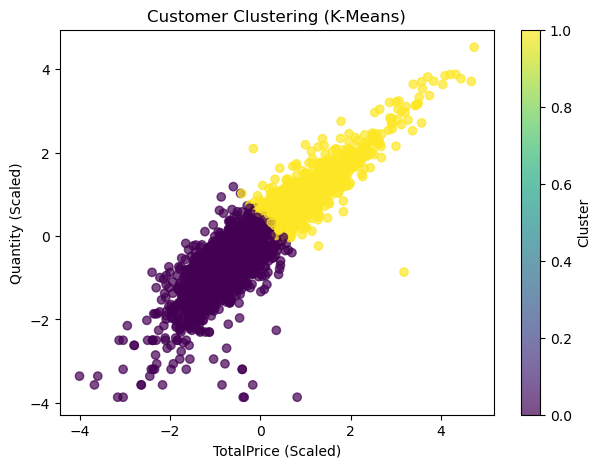

In [21]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

print(customer_data.groupby('Cluster').mean())

plt.figure(figsize=(7,5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.title("Customer Clustering (K-Means)")
plt.colorbar(label="Cluster")
plt.show()

In [22]:
customer_data.head()

,TotalPrice,Quantity,NumTransactions,Cluster
CustomerID,,,,
12346.0,11.253955,11.214735,1,1
12347.0,8.368925,7.807510,7,1
12348.0,7.494564,7.758761,4,1
12349.0,7.472245,6.448889,1,1
12350.0,5.815324,5.288267,1,0


Number of clusters (excluding noise): 4
Noise points (Cluster -1): 59


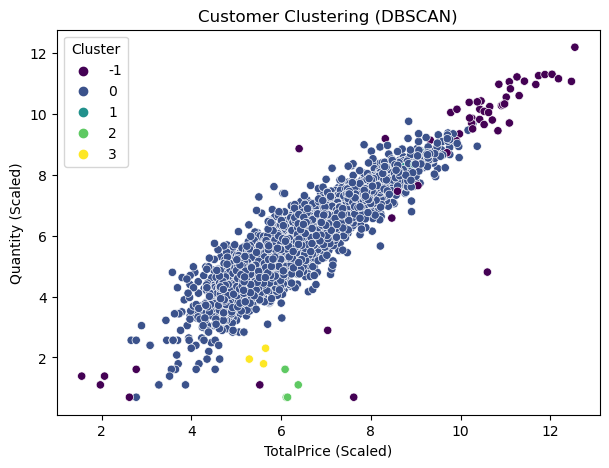

 0    4266
-1      59
 1       5
 2       5
 3       3
Name: DBSCAN_Cluster, dtype: int64


In [23]:
dbscan = DBSCAN(eps=0.5, min_samples=5) 
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

print("Number of clusters (excluding noise):", len(set(customer_data['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_data['DBSCAN_Cluster'] == -1).sum())

plt.figure(figsize=(7,5))
sns.scatterplot(x=customer_data['TotalPrice'], y=customer_data['Quantity'], hue=customer_data['DBSCAN_Cluster'], palette="viridis")
plt.title("Customer Clustering (DBSCAN)")
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.legend(title="Cluster")
plt.show()

print(customer_data['DBSCAN_Cluster'].value_counts())


K-Means Silhouette Score: 0.495

K-Means Cluster Counts:
 0    2656
1    1682
Name: Cluster, dtype: int64

DBSCAN Cluster Counts:
  0    4266
-1      59
 1       5
 2       5
 3       3
Name: DBSCAN_Cluster, dtype: int64


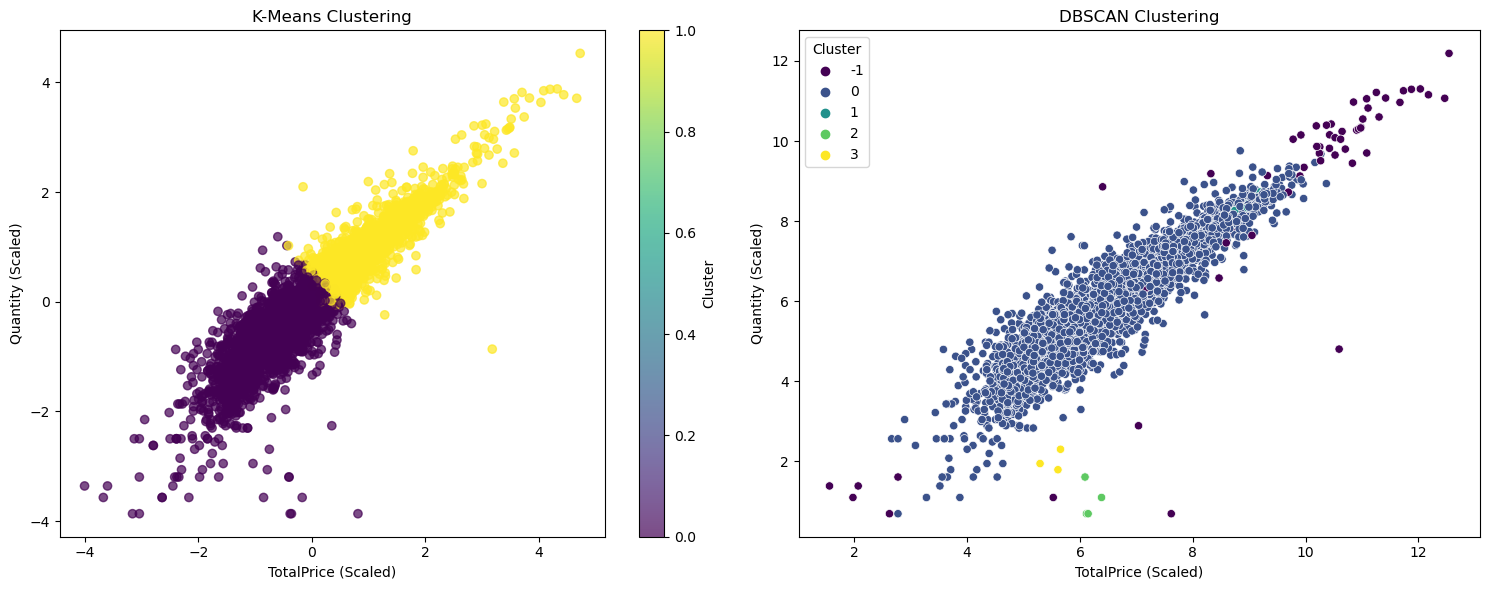

In [24]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(X_scaled, customer_data['Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

print("\nK-Means Cluster Counts:\n", customer_data['Cluster'].value_counts())
print("\nDBSCAN Cluster Counts:\n", customer_data['DBSCAN_Cluster'].value_counts())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc = ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel("TotalPrice (Scaled)")
ax1.set_ylabel("Quantity (Scaled)")
fig.colorbar(sc, ax=ax1, label="Cluster")  

sns.scatterplot(x=customer_data['TotalPrice'], y=customer_data['Quantity'], hue=customer_data['DBSCAN_Cluster'], palette="viridis", ax=ax2)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel("TotalPrice (Scaled)")
ax2.set_ylabel("Quantity (Scaled)")
ax2.legend(title="Cluster")

plt.tight_layout()
plt.show()